### Comparing loss/validation curves and final scores across experiments

TODO: 
   - test multi-task setups appear correctly (not urgent ...) 

In [1]:
import pandas as pds
import os.path
from glob import glob
import altair as alt
import json
%matplotlib inline

from collect_scores import config, tasks as seg_tasks, pdtb_tasks, models, collect_final_result
# only for testing, not really needed here
from collect_scores import retrieve_expe_dir, get_taskname_from_dir, collect_expe_results, get_last_run, get_log

/home/muller/miniconda3/envs/jiant3.8/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [197]:
RUN_DIR = "../runs"

config["exp_dir"] = RUN_DIR
config["tasks"] =  seg_tasks | pdtb_tasks # | {"spa_rst_merged"}
TEST_TASK = "deu_rst_pcc"



In [198]:
config

{'exp_dir': '../runs',
 'tasks': {'deu_rst_pcc',
  'eng_dep_scidtb',
  'eng_pdtb_pdtb',
  'eng_rst_gum',
  'eng_rst_rstdt',
  'eng_sdrt_stac',
  'eus_rst_ert',
  'fas_rst_prstc',
  'fra_sdrt_annodis',
  'ita_pdtb_luna',
  'nld_rst_nldt',
  'por_pdtb_crpc',
  'por_rst_cstn',
  'rus_rst_rrt',
  'spa_rst_rststb',
  'spa_rst_sctb',
  'tha_pdtb_tdtb',
  'tur_pdtb_tdb',
  'zho_dep_scidtb',
  'zho_pdtb_cdtb',
  'zho_rst_gcdt',
  'zho_rst_sctb'},
 'models': {'bert': 'bert-base-multilingual-uncased',
  'roberta': 'xlm-roberta-base',
  'roberta-large': 'xlm-roberta-large'}}

In [199]:
val_scores = collect_final_result(config["tasks"],["roberta","roberta-large","bert"],config,task_type="split",best_metadata=False)
val_scores = pds.concat((val_scores,collect_final_result(config["tasks"],["roberta","roberta-large","bert"],config,task_type="conllu",best_metadata=False)))

# this should be read from args/config; hardcoded for now
val_scores["real_batch_size"] = val_scores["real_batch_size"].astype(int)

#val_scores["epochs"].replace(to_replace=[None],value=30,inplace=True)
#val_scores["epochs"] = val_scores["epochs"].astype(int)
# default -> replace
val_scores["max_seq_length"].replace([None],180,inplace=True)

val_scores["patience"] = 10
#val_scores["eval steps"] = 500
#val_scores["setup"] = "jiant single"
val_scores["train corpus"] = val_scores["task"]
################
val_scores = val_scores.reset_index(drop=True)
val_scores.sort_values(by=["task","model","real_batch_size"])


,task,task_type,precision,recall,f1,freeze_layers,learning_rate,real_batch_size,eval_subset_num,epochs,max_seq_length,setup,model,patience,train corpus
40,deu_rst_pcc,split,0.945652,0.949091,0.947368,,0.00001,64,500.0,None,180,single,roberta,10,deu_rst_pcc
41,deu_rst_pcc,split,0.962406,0.930909,0.946396,0-7,0.00001,64,500.0,30.0,180,single,roberta,10,deu_rst_pcc
42,deu_rst_pcc,split,0.956044,0.949091,0.952555,0-2,0.00001,64,500.0,30.0,180,single,roberta,10,deu_rst_pcc
137,deu_rst_pcc,conllu,0.963235,0.952727,0.957952,,0.00001,64,500.0,None,180,single,roberta,10,deu_rst_pcc
43,deu_rst_pcc,split,0.963370,0.956364,0.959854,0-11,0.00001,4,500.0,30.0,180,single,roberta-large,10,deu_rst_pcc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,zho_rst_sctb,split,0.635514,0.660194,0.647619,0-11,0.00001,4,500.0,30.0,180,single,roberta-large,10,zho_rst_sctb
97,zho_rst_sctb,split,0.709677,0.854369,0.775330,0-5,0.00001,4,500.0,30.0,180,single,roberta-large,10,zho_rst_sctb
202,zho_rst_sctb,conllu,0.725490,0.718447,0.721951,0-12,0.00001,4,500.0,None,180,single,roberta-large,10,zho_rst_sctb
204,zho_rst_sctb,conllu,0.775701,0.805825,0.790476,0-5,0.00001,4,500.0,30.0,180,single,roberta-large,10,zho_rst_sctb


In [200]:
columns = ["train corpus","task","task_type","model","precision","recall","f1","setup","real_batch_size","learning_rate","freeze_layers","epochs","patience","max_seq_length"]

formatter = formatter={('learning_rate'): '{:.2g}'.format,
                                   ('f1'):'{:.2%}'.format,
                                   ('precision'):'{:.2%}'.format,
                                   ('recall'):'{:.2%}'.format,
                          }
# ~val_scores["task"].str.contains("pdtb") ou non
#scores = val_scores[val_scores["task"].str.contains("pdtb")].sort_values(by=["task_type","task","model"])
scores = val_scores.sort_values(by=["task_type","task","model"])
#scores[].to_latex())
scores[columns].to_csv("scores.csv",index=False)
scores[columns].style.format(formatter=formatter)

,train corpus,task,task_type,model,precision,recall,f1,setup,real_batch_size,learning_rate,freeze_layers,epochs,patience,max_seq_length
137,deu_rst_pcc,deu_rst_pcc,conllu,roberta,96.32%,95.27%,95.80%,single,64,1e-05,,None,10,180
138,deu_rst_pcc,deu_rst_pcc,conllu,roberta-large,96.74%,97.09%,96.91%,single,4,1e-05,0-11,None,10,180
139,deu_rst_pcc,deu_rst_pcc,conllu,roberta-large,96.04%,97.09%,96.56%,single,4,1e-05,0-5,30.000000,10,180
159,eng_dep_scidtb,eng_dep_scidtb,conllu,roberta,94.04%,97.04%,95.52%,single,64,1e-05,,None,10,180
160,eng_dep_scidtb,eng_dep_scidtb,conllu,roberta-large,95.84%,96.15%,95.99%,single,4,1e-05,0-12,None,10,180
161,eng_dep_scidtb,eng_dep_scidtb,conllu,roberta-large,94.72%,96.76%,95.73%,single,4,1e-05,0-5,30.000000,10,180
162,eng_pdtb_pdtb,eng_pdtb_pdtb,conllu,roberta,56.88%,16.05%,25.04%,single,64,1e-05,0-7,30.000000,10,180
163,eng_pdtb_pdtb,eng_pdtb_pdtb,conllu,roberta,93.67%,94.65%,94.15%,single,64,1e-05,0-7,30.000000,10,180
164,eng_pdtb_pdtb,eng_pdtb_pdtb,conllu,roberta,93.40%,95.07%,94.23%,single,64,1e-05,0-7,30.000000,10,180
166,eng_pdtb_pdtb,eng_pdtb_pdtb,conllu,roberta-large,95.86%,92.34%,94.07%,single,4,1e-05,0-12,None,10,180


In [201]:
scores[columns].style.bar(subset=['f1'], color='green').format(formatter=formatter)

,train corpus,task,task_type,model,precision,recall,f1,setup,real_batch_size,learning_rate,freeze_layers,epochs,patience,max_seq_length
137,deu_rst_pcc,deu_rst_pcc,conllu,roberta,96.32%,95.27%,95.80%,single,64,1e-05,,None,10,180
138,deu_rst_pcc,deu_rst_pcc,conllu,roberta-large,96.74%,97.09%,96.91%,single,4,1e-05,0-11,None,10,180
139,deu_rst_pcc,deu_rst_pcc,conllu,roberta-large,96.04%,97.09%,96.56%,single,4,1e-05,0-5,30.000000,10,180
159,eng_dep_scidtb,eng_dep_scidtb,conllu,roberta,94.04%,97.04%,95.52%,single,64,1e-05,,None,10,180
160,eng_dep_scidtb,eng_dep_scidtb,conllu,roberta-large,95.84%,96.15%,95.99%,single,4,1e-05,0-12,None,10,180
161,eng_dep_scidtb,eng_dep_scidtb,conllu,roberta-large,94.72%,96.76%,95.73%,single,4,1e-05,0-5,30.000000,10,180
162,eng_pdtb_pdtb,eng_pdtb_pdtb,conllu,roberta,56.88%,16.05%,25.04%,single,64,1e-05,0-7,30.000000,10,180
163,eng_pdtb_pdtb,eng_pdtb_pdtb,conllu,roberta,93.67%,94.65%,94.15%,single,64,1e-05,0-7,30.000000,10,180
164,eng_pdtb_pdtb,eng_pdtb_pdtb,conllu,roberta,93.40%,95.07%,94.23%,single,64,1e-05,0-7,30.000000,10,180
166,eng_pdtb_pdtb,eng_pdtb_pdtb,conllu,roberta-large,95.86%,92.34%,94.07%,single,4,1e-05,0-12,None,10,180


In [205]:
comp = scores[scores["model"].str.contains("roberta")][["task","model","f1","freeze_layers","task_type"]]#.groupby("freeze_layers")["f1"].max()
comp["modelX"] = comp["model"]+"_"+comp["freeze_layers"]
comp = comp.groupby(["task_type","task"]).max()
#comp.sort_values(by="task_type",inplace=True)
#comp.set_index(["task_type","task","modelX"],inplace=True)
#comp.loc["conllu"].max()
#comp.loc["split","tur_pdtb_tedm"]

In [216]:
comp.loc["conllu"].filter(like="pdtb",axis=0)

TypeError: filter() got an unexpected keyword argument 'unlike'

In [214]:
scores[scores["model"]=="roberta-large"].groupby(["task_type","task"]).max()

precision    recall        f1 freeze_layers  \
task_type task                                                            
conllu    deu_rst_pcc        0.967391  0.970909  0.969147           0-5   
          eng_dep_scidtb     0.958353  0.967606  0.959925           0-5   
          eng_pdtb_pdtb      0.958606  0.937041  0.944974          0-12   
          eng_pdtb_tedm      0.823529  0.763636  0.792453          0-11   
          eng_rst_gum        0.820611  0.847670  0.833921          0-12   
          eng_rst_rstdt      0.968733  0.984975  0.975691           0-5   
          eng_sdrt_stac      0.955326  0.963605  0.959448           0-5   
          eus_rst_ert        0.936073  0.908419  0.922039           0-5   
          fas_rst_prstc      0.947368  0.937500  0.942408           0-5   
          fra_sdrt_annodis   0.910816  0.884892  0.887286           0-5   
          ita_pdtb_luna      0.852174  0.719424  0.771654           0-5   
          nld_rst_nldt       0.976540  0.970845  0.973684           0-5   
          por_pdtb_crpc      0.840764  0.870759  0.846832           0-8   
          por_pdtb_tedm      0.669565  0.754902  0.709677           0-8   
          por_rst_cstn       0.951220  0.960317  0.939759           0-5   
          rus_rst_rrt        0.853760  0.875858  0.857185           0-5   
          spa_rst_rststb     0.959620  0.976134  0.963486           0-5   
          spa_rst_sctb       0.915789  0.902913  0.889952           0-8   
          tha_pdtb_tdtb      0.908957  0.945760  0.926994           0-5   
          tur_pdtb_tdb       0.909091  0.902292  0.900791           0-5   
          zho_dep_scidtb     0.761905  0.374582  0.502242           0-5   
          zho_pdtb_cdtb      0.894389  0.863057  0.878444           0-5   
          zho_rst_gcdt       0.928885  0.937112  0.932981           0-5   
          zho_rst_sctb       0.775701  0.805825  0.790476           0-5   
split     deu_rst_pcc        0.963768  0.967273  0.965517           0-5   
          eng_dep_scidtb     0.962139  0.963850  0.958284           0-5   
          eng_pdtb_pdtb      0.943218  0.941238  0.942227           0-5   
          eng_rst_gum        0.841459  0.838652  0.839254           0-5   
          eng_rst_rstdt      0.971239  0.978297  0.974202           0-5   
          eng_sdrt_stac      0.908703  0.922877  0.915735           0-5   
          eus_rst_ert        0.938776  0.898080  0.916353           0-5   
          fas_rst_prstc      0.934820  0.946181  0.940466           0-5   
          fra_sdrt_annodis   0.896552  0.915468  0.901683           0-5   
          ita_pdtb_luna      0.806452  0.722222  0.746269           0-5   
          nld_rst_nldt       0.968116  0.973761  0.970930           0-5   
          por_pdtb_crpc      0.853420  0.867742  0.849271           0-5   
          por_pdtb_tedm      0.714286  0.735294  0.724638           0-5   
          por_rst_cstn       0.950739  0.947619  0.935004           0-5   
          rus_rst_rrt        0.848521  0.859319  0.852556           0-5   
          spa_rst_rststb     0.957547  0.968974  0.963227           0-5   
          spa_rst_sctb       0.888889  0.854369  0.871287           0-5   
          tha_pdtb_tdtb      0.894938  0.948381  0.920885           0-5   
          tur_pdtb_tdb       0.886659  0.916767  0.896181           0-5   
          zho_dep_scidtb     0.748299  0.367893  0.493274           0-5   
          zho_pdtb_cdtb      0.900332  0.863057  0.881301           0-5   
          zho_rst_gcdt       0.924429  0.935111  0.929739           0-5   
          zho_rst_sctb       0.709677  0.854369  0.775330           0-5   

                            learning_rate  real_batch_size  eval_subset_num  \
task_type task                                                                
conllu    deu_rst_pcc             0.00001                4            500.0   
          eng_dep_scidtb          0.00001                4            500.0   
          eng_pdtb_pdtb           0.

In [182]:
#comp.groupby(level=[0,1]).max()

In [183]:
comp["f1"]

task_type  task         
conllu     eng_pdtb_pdtb    0.944974
           eng_pdtb_tedm    0.792453
           ita_pdtb_luna    0.771654
           por_pdtb_crpc    0.846832
           por_pdtb_tedm    0.726415
           tha_pdtb_tdtb    0.926994
           tur_pdtb_tdb     0.906714
           tur_pdtb_tedm    0.647619
           zho_pdtb_cdtb    0.878444
split      eng_pdtb_pdtb    0.950923
           ita_pdtb_luna    0.746269
           por_pdtb_crpc    0.849271
           por_pdtb_tedm    0.724638
           tha_pdtb_tdtb    0.920885
           tur_pdtb_tdb     0.908115
           zho_pdtb_cdtb    0.881301
Name: f1, dtype: float64

In [184]:
def highlight_min(data):
    color= 'red'
    attr = 'background-color: {}'.format(color)

    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else: 
        is_min = data.groupby(level=0).transform('min') == data
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

# Apply the function to the DataFrame using the style module
highlighted_df = comp.style.apply(highlight_max,axis=0)
highlighted_df

In [186]:
xlmb = scores[scores["model"]=="roberta"].groupby("task")["f1"].max()
xlml = scores[scores["model"]=="roberta-large"].groupby("task")["f1"].max()
xlme = scores[scores["model"]=="bert"].groupby("task")["f1"].max()

100*(xlml-xlmb)


task
eng_pdtb_pdtb   -0.594994
eng_pdtb_tedm    2.532954
ita_pdtb_luna    0.305850
por_pdtb_crpc    2.454453
por_pdtb_tedm   -0.177741
tha_pdtb_tdtb    0.408375
tur_pdtb_tdb    -0.732332
tur_pdtb_tedm         NaN
zho_pdtb_cdtb    3.919555
Name: f1, dtype: float64

In [57]:
import pandas as pd

# Create a sample DataFrame with a multi-index
data = {
    'Category': ['A', 'A', 'B', 'B', 'C', 'C'],
    'Subcategory': [1, 2, 1, 2, 1, 2],
    'Value': [10, 20, 30, 40, 50, 60]
}
df = pd.DataFrame(data)
df.set_index(['Category', 'Subcategory'], inplace=True)

# Define a function to highlight the maximum value in the "Value" column
def highlight_max(s):
    is_max = s['Value'] == s['Value'].max()
    return ['background-color: yellow' if v else '' for v in is_max]

# Apply the function to the DataFrame using the style module
highlighted_df = df.style.apply(highlight_max, axis=1)

# Display the highlighted DataFrame
highlighted_df

TypeError: 'numpy.bool_' object is not iterable

In [112]:
xlme

Series([], Name: f1, dtype: float64)

In [113]:
xlmb = scores[scores["model"]=="roberta"].groupby("task")["f1"].max()
xlml = scores[scores["model"]=="roberta-large"].groupby("task")["f1"].max()
xlml-xlmb

task
eng_pdtb_pdtb   -0.008697
ita_pdtb_luna    0.746269
por_pdtb_crpc    0.024579
por_pdtb_tedm         NaN
tha_pdtb_tdtb    0.008282
tur_pdtb_tdb    -0.011933
zho_pdtb_cdtb    0.039196
Name: f1, dtype: float64

In [114]:
xlmb

task
eng_pdtb_pdtb    0.950923
ita_pdtb_luna    0.000000
por_pdtb_crpc    0.824691
tha_pdtb_tdtb    0.912603
tur_pdtb_tdb     0.908115
zho_pdtb_cdtb    0.842105
Name: f1, dtype: float64

In [115]:

TEST_TASK = "zho_dep_scidtb"

test_dir = retrieve_expe_dir(TEST_TASK,"conllu","roberta",config)
print(test_dir)
print(get_taskname_from_dir(test_dir))
path = get_last_run(test_dir)
log = get_log(path,"metrics")
df = collect_expe_results([TEST_TASK],"conllu",["roberta","roberta-large"],config)
df


../runs/run_disrpt23_zho_dep_scidtb_conllu_xlm-roberta-base
disrpt23_zho_dep_scidtb
../runs/run_disrpt23_zho_dep_scidtb_conllu_xlm-roberta-base/1682342664
../runs/run_disrpt23_zho_dep_scidtb_conllu_xlm-roberta-large/1683778331
../runs/run_disrpt23_zho_dep_scidtb_conllu_xlm-roberta-base/1682342664
../runs/run_disrpt23_zho_dep_scidtb_conllu_xlm-roberta-large/1683778331


,task,f1,precision,recall,task_step,global_step,setup,model,task_type,loss_val,TIMESTAMP
0,zho.dep.scidtb,0.506849,0.798561,0.371237,99,99,single,roberta,conllu,NaN,NaT
1,zho.dep.scidtb,0.507937,0.788732,0.374582,199,199,single,roberta,conllu,NaN,NaT
2,zho.dep.scidtb,0.503341,0.753333,0.377926,299,299,single,roberta,conllu,NaN,NaT
3,zho.dep.scidtb,0.505695,0.792857,0.371237,399,399,single,roberta,conllu,NaN,NaT
4,zho.dep.scidtb,0.513889,0.834586,0.371237,499,499,single,roberta,conllu,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...
2919,disrpt23_zho_dep_scidtb_conllu,NaN,NaN,NaN,2306,2306,single,roberta-large,conllu,0.035707,2023-05-11 04:34:55.812336384
2920,disrpt23_zho_dep_scidtb_conllu,NaN,NaN,NaN,2307,2307,single,roberta-large,conllu,0.049637,2023-05-11 04:34:56.413307136
2921,disrpt23_zho_dep_scidtb_conllu,NaN,NaN,NaN,2308,2308,single,roberta-large,conllu,0.048042,2023-05-11 04:34:56.964681728
2922,disrpt23_zho_dep_scidtb_conllu,NaN,NaN,NaN,2309,2309,single,roberta-large,conllu,0.004064,2023-05-11 04:34:57.556031744


,task,f1,precision,recall,task_step,global_step,setup,model,task_type,loss_val,TIMESTAMP
0,zho.dep.scidtb,0.506849,0.798561,0.371237,99,99,single,roberta,conllu,NaN,NaT
1,zho.dep.scidtb,0.507937,0.788732,0.374582,199,199,single,roberta,conllu,NaN,NaT
2,zho.dep.scidtb,0.503341,0.753333,0.377926,299,299,single,roberta,conllu,NaN,NaT
3,zho.dep.scidtb,0.505695,0.792857,0.371237,399,399,single,roberta,conllu,NaN,NaT
4,zho.dep.scidtb,0.513889,0.834586,0.371237,499,499,single,roberta,conllu,NaN,NaT
5,zho.dep.scidtb,0.503401,0.781690,0.371237,599,599,single,roberta,conllu,NaN,NaT
6,zho.dep.scidtb,0.503401,0.781690,0.371237,600,600,single,roberta,conllu,NaN,NaT
7,zho.dep.scidtb,0.503401,0.781690,0.371237,600,600,single,roberta,conllu,NaN,NaT
8,zho.dep.scidtb,0.368039,0.666667,0.254181,499,499,single,roberta-large,conllu,NaN,NaT
9,zho.dep.scidtb,0.424508,0.613924,0.324415,999,999,single,roberta-large,conllu,NaN,NaT


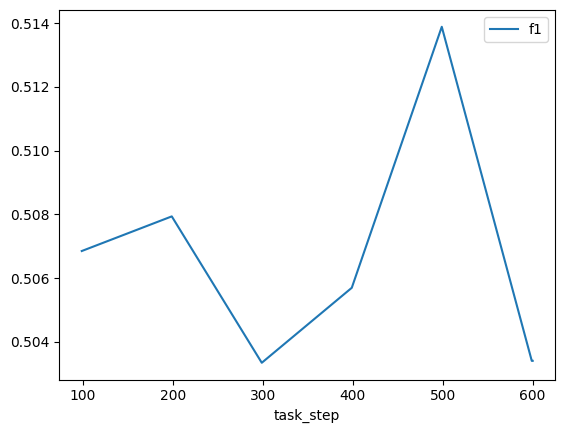

In [116]:
# Example visualizations of loss/validation curves
#alt.data_transformers.disable_max_rows()
TEST_TASK = TEST_TASK.replace("_",".")
filter = (df["task"]==TEST_TASK) & (df["model"]=="roberta") #& (df["global_step"]<5000)
df[filter].plot(x="task_step",y="f1")
df[(df["task"]==TEST_TASK)]

In [117]:
# doesnt show ... why ? interpreter problem ?
# alt.renderers.enable('default')

raw_loss = alt.Chart(df[filter]).mark_line().encode(
  x='task_step',# or global_step
  y='loss_val',
  color='model:N' # setup or model
)

raw_f1 = alt.Chart(df[filter & (df["f1"].notnull())]).mark_point().encode(
  x='task_step',# global_step
  y='f1',
  color='model:N'
)

f1_labels = raw_f1.mark_text(
    align="center",
    dy= -20
).encode(text=alt.Text("f1:Q",format=".1%"))

# rolling average 
avg_loss = alt.Chart(df[filter]).mark_line(color="green"
).transform_window(
    rolling_mean='mean(loss_val)',
    frame=[-10,0]
).encode(
    x='task_step',# global_step
    y='rolling_mean:Q',
    color="model:N"
    #color="task:N"
)

#alt.layer(avg_loss + raw_f1).interactive() #+ f1_labels
avg_loss | (raw_f1 + f1_labels)

/home/muller/miniconda3/envs/jiant3.8/lib/python3.8/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.HConcatChart(...)

In [118]:

filter = val_scores["task"].isin(pdtb_tasks)
print("===== Scores pdtb ========")
print("---mean=",val_scores[filter].groupby("model").mean()["f1"])
print("---std dev=",val_scores[filter].groupby("model").std()["f1"])
filter = ~(val_scores["task"].isin(pdtb_tasks))
print("===== Scores segmentation ========")
print("---mean=",val_scores[filter].groupby("model").mean()["f1"])
print("---std dev=",val_scores[filter].groupby("model").std()["f1"])

/tmp/ipykernel_651116/1181446257.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print("---mean=",val_scores[filter].groupby("model").mean()["f1"])
/tmp/ipykernel_651116/1181446257.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print("---std dev=",val_scores[filter].groupby("model").std()["f1"])
/tmp/ipykernel_651116/1181446257.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print("---mean=",val_scores[fil

===== Scores pdtb ========
---mean= model
roberta          0.731597
roberta-large    0.863851
Name: f1, dtype: float64
---std dev= model
roberta          0.345427
roberta-large    0.064988
Name: f1, dtype: float64
===== Scores segmentation ========
---mean= model
roberta          0.850979
roberta-large    0.877948
Name: f1, dtype: float64
---std dev= model
roberta          0.172986
roberta-large    0.127968
Name: f1, dtype: float64


/tmp/ipykernel_651116/1181446257.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print("---std dev=",val_scores[filter].groupby("model").std()["f1"])


In [119]:
# to compare multiple models across multiple datasets + CI
# better if averaged on multiple runs
# inspired from: https://altair-viz.github.io/gallery/grouped_bar_chart_with_error_bars.html
scores = alt.Chart().mark_bar().encode(
    x="model",
    y="f1",
    color="model"
)

error_bars = alt.Chart().mark_errorbar(extent='ci').encode(
    x='model',
    y='f1'
)
f1_labels = scores.mark_text(
    align="left",
    dy= -20, dx=-10
).encode(text=alt.Text("f1:Q",format=".1%"))


alt.layer(scores, error_bars, f1_labels,data=val_scores).facet(
    column='task:N'
).interactive()

/home/muller/miniconda3/envs/jiant3.8/lib/python3.8/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.FacetChart(...)